In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader, get_eval_loader
from wilds.common.grouper import CombinatorialGrouper
from wilds.datasets.wilds_dataset import WILDSSubset

from models import DeepDANN
from mixup import mixup_criterion
import options
import random

from main import get_wilds_dataset, get_split, get_eval_loader, build_model
from main import NUM_CLASSES, DEFAULT_TRANSFORM, NUM_DOMAINS, METADATA_KEYS

import sklearn
from sklearn.manifold import TSNE 

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

cam_mix = 'weights/camelyon-mixup.pth'
cam_nomix = 'weights/camelyon-nomixup_final_2021-05-26T17:56:21.262615.pth'
iwild_mix = 'weights/iwildcam-mixup-3epoch_final_2021-05-25T18:25:23.230189.pth'
iwild_nomix = 'weights/from-ep2-iwildcam-mixup-3epoch_final_2021-05-26T05:52:54.712932.pth'

In [2]:
def scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, img_name):
    fig, ax = plt.subplots()
    train_fig = sns.scatterplot(x=d_train[:,0], y=d_train[:,1],hue=Y_train,palette=sns.color_palette("Blues",np.unique(Y_train).shape[0]),alpha=0.7,ax=ax)
    val_fig = sns.scatterplot(x=d_val[:,0], y=d_val[:,1],hue=Y_val,palette=sns.color_palette("Greens",np.unique(Y_val).shape[0]),alpha=0.7,ax=ax)
    test_fig = sns.scatterplot(x=d_test[:,0], y=d_test[:,1],hue=Y_test,palette=sns.color_palette("Oranges",np.unique(Y_test).shape[0]),alpha=0.7,ax=ax)


    train_fig.tick_params(bottom=False, left=False)
    train_fig.set(xticklabels=[])
    train_fig.set(yticklabels=[])
    train_norm = plt.Normalize(Y_train.min(), Y_train.max())
    train_sm = plt.cm.ScalarMappable(cmap="Blues", norm=train_norm)
    train_sm.set_array([])
    train_cax = fig.add_axes([0.25, 0.1, 0.15, 0.01])
    ax.figure.colorbar(train_sm,label="Train", ticks=[], cax=train_cax, orientation = 'horizontal')


    val_fig.tick_params(bottom=False, left=False)
    val_fig.set(xticklabels=[])
    val_fig.set(yticklabels=[])
    val_norm = plt.Normalize(Y_val.min(), Y_val.max())
    val_sm = plt.cm.ScalarMappable(cmap="Greens", norm=val_norm)
    val_sm.set_array([])
    val_cax = fig.add_axes([0.45, 0.1, 0.15, 0.01])
    ax.figure.colorbar(val_sm, label="Val", ticks=[], cax=val_cax, orientation='horizontal')

    test_fig.tick_params(bottom=False, left=False)
    test_fig.set(xticklabels=[])
    test_fig.set(yticklabels=[])
    test_norm = plt.Normalize(Y_test.min(), Y_test.max())
    test_sm = plt.cm.ScalarMappable(cmap="Oranges", norm=test_norm)
    test_sm.set_array([])
    test_cax = fig.add_axes([0.65, 0.1, 0.15, 0.01])
    ax.figure.colorbar(test_sm,label="Test", ticks=[], cax=test_cax, orientation='horizontal')


    fig.set_size_inches([6,5],forward=True)
    ax.get_legend().remove()
    sns.despine(bottom = True, left = True, right=True,ax=ax)

    fig.savefig(img_name)

In [3]:
dataset = get_wilds_dataset('iwildcam', '../WILDS')
train_data = get_split(dataset, 'train', transforms=DEFAULT_TRANSFORM['iwildcam'])
test_data = get_split(dataset, 'test', transforms=DEFAULT_TRANSFORM['iwildcam'])
val_data = get_split(dataset, 'val', transforms=DEFAULT_TRANSFORM['iwildcam'])
grouper = CombinatorialGrouper(dataset, [METADATA_KEYS['iwildcam']])
train_loader = get_train_loader('group', train_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)
val_loader = get_train_loader('group', val_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)
test_loader = get_train_loader('group', test_data, batch_size=20, uniform_over_groups=True, grouper=grouper, distinct_groups=True, n_groups_per_batch=1)

[INFO] 2021-06-02 09:25:51,998 main.py:52 - Loaded dataset iwildcam with 203029 examples



# Run Non Mix Up Experiments Below

In [4]:
# no mix up
model = build_model('resnet50', NUM_CLASSES['iwildcam'], NUM_DOMAINS['iwildcam'], 1, -1)
model.load_state_dict(torch.load(iwild_nomix))
for p in model.parameters():
        p.requires_grad = False
model.eval()
extractor = model.feature_extractor

In [5]:
# no mix up
i = 0
val_features, val_ids = [], []
test_features, test_ids = [], []
train_features, train_ids = [], []

# val data
for x, y_true, metadata in val_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    val_features.append(y_pred.cpu().numpy())
    val_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 5:
        break
val_features = np.array(val_features).reshape(-1, 2048)
val_ids = np.array(val_ids).reshape(-1)
print(val_features.shape, val_ids.shape)
val_id = np.unique(val_ids)
print("val id: ", val_id)

# test data
for x, y_true, metadata in test_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    test_features.append(y_pred.cpu().numpy())
    test_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 13:
        break
test_features = np.array(test_features).reshape(-1, 2048)
test_ids = np.array(test_ids).reshape(-1)
print(test_features.shape, test_ids.shape)
test_id = np.unique(test_ids)
print("test id: ", test_id)

# train data
for x, y_true, metadata in train_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    train_features.append(y_pred.cpu().numpy())
    train_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 50:
        break
train_features = np.array(train_features).reshape(-1, 2048)
train_ids = np.array(train_ids).reshape(-1)
print(train_features.shape, train_ids.shape)
train_id = np.unique(train_ids)
print("val id: ", train_id)

print(i)

(100, 2048) (100,)
val id:  [ 27  79 114 154]
(160, 2048) (160,)
test id:  [ 29  78 120 169 176 288 301]
(740, 2048) (740,)
val id:  [ 14  16  39  52  54  55  65  84  97  99 102 106 118 138 180 197 201 202
 209 216 220 229 246 248 250 254 257 292 294 295 296 305 308 319 322]
50


In [6]:
# no mix up

X_train = np.vstack([train_features[train_ids==i] for i in train_id])
Y_train = np.hstack([train_ids[train_ids==i] for i in train_id])
print("train:",np.array(X_train).shape, np.array(Y_train).shape)

X_val = np.vstack([val_features[val_ids==i] for i in val_id])
Y_val = np.hstack([val_ids[val_ids==i] for i in val_id])
print("val:",np.array(X_val).shape, np.array(Y_val).shape)

X_test = np.vstack([test_features[test_ids==i] for i in test_id])
Y_test = np.hstack([test_ids[test_ids==i] for i in test_id])
print("test:",np.array(X_test).shape, np.array(Y_test).shape)


pca = PCA(n_components=100)
pca.fit(X_train)
print(pca.singular_values_)

pca = PCA(n_components=100)
pca.fit(X_val)
print(pca.singular_values_)

pca = PCA(n_components=100)
pca.fit(X_test)
print(pca.singular_values_)


train: (740, 2048) (740,)
val: (100, 2048) (100,)
test: (160, 2048) (160,)
[204.41171  165.70328  148.34612  135.30937  115.68527  100.53956
  93.3614    89.71137   86.752754  82.85928   79.949524  77.681885
  69.83737   66.28753   63.43874   59.689426  55.747547  55.12275
  52.04302   50.456787  48.036385  45.666782  42.87813   40.763012
  38.108025  38.071957  36.058437  34.36577   33.961445  33.354034
  30.559795  30.0584    28.642334  27.946379  26.848999  26.043013
  25.399788  25.117817  23.74451   23.263557  22.583025  21.972326
  21.340569  20.993925  20.258688  19.818148  19.390158  18.030682
  17.799126  17.478178  16.411995  16.317854  16.067987  15.764146
  15.469684  15.342378  14.9447    14.696614  14.328435  14.154874
  13.80558   13.434135  13.270918  13.033418  12.685704  12.508681
  12.349727  12.079945  11.862346  11.789565  11.688444  11.28483
  11.225903  11.102833  10.699825  10.636545  10.48001   10.366569
  10.301838  10.179483   9.959444   9.938247   9.834533  

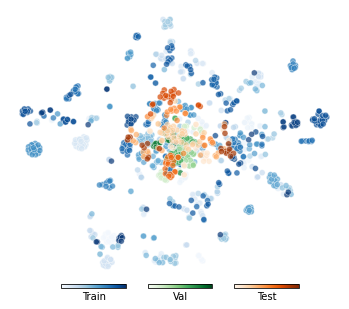

In [7]:
# no mix up
X_train_PCA = PCA(n_components=100).fit_transform(X_train)
d_train = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)

X_val_PCA = PCA(n_components=100).fit_transform(X_val)
d_val = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=100).fit_transform(X_test)
d_test = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_no_30.png")

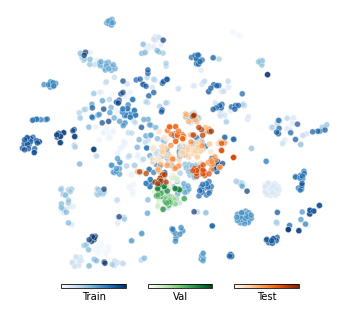

In [8]:
# no mix up
X_train_PCA = PCA(n_components=100).fit_transform(X_train)
d_train = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)

X_val_PCA = PCA(n_components=100).fit_transform(X_val)
d_val = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=100).fit_transform(X_test)
d_test = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_no_50.png")

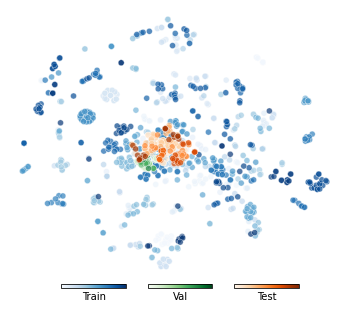

In [9]:
# no mix up
X_train_PCA = PCA(n_components=100).fit_transform(X_train)
d_train = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)

X_val_PCA = PCA(n_components=100).fit_transform(X_val)
d_val = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=100).fit_transform(X_test)
d_test = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_no_80.png")


# Run Mix Up Experiments Below

In [10]:
# mix up
model = build_model('resnet50', NUM_CLASSES['iwildcam'], NUM_DOMAINS['iwildcam'], 1, 1)
model.load_state_dict(torch.load(iwild_mix))
for p in model.parameters():
        p.requires_grad = False
model.eval()
extractor = model.feature_extractor

In [11]:
# mix up
i = 0
val_features, val_ids = [], []
test_features, test_ids = [], []
train_features, train_ids = [], []

# val data
for x, y_true, metadata in val_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    val_features.append(y_pred.cpu().numpy())
    val_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 5:
        break
val_features = np.array(val_features).reshape(-1, 2048)
val_ids = np.array(val_ids).reshape(-1)
print(val_features.shape, val_ids.shape)
val_id = np.unique(val_ids)
print("val id: ", val_id)

# test data
for x, y_true, metadata in test_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    test_features.append(y_pred.cpu().numpy())
    test_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 13:
        break
test_features = np.array(test_features).reshape(-1, 2048)
test_ids = np.array(test_ids).reshape(-1)
print(test_features.shape, test_ids.shape)
test_id = np.unique(test_ids)
print("test id: ", test_id)

# train data
for x, y_true, metadata in train_loader:
    # x: batch_size*3*448*448
    # y_true: batch_size
    # y_pred: batch_size * 2048
    groupids = grouper.metadata_to_group(metadata)
    y_pred = extractor(x.to('cuda'))
    train_features.append(y_pred.cpu().numpy())
    train_ids.append(groupids.cpu().numpy())
    i += 1
    if i == 50:
        break
train_features = np.array(train_features).reshape(-1, 2048)
train_ids = np.array(train_ids).reshape(-1)
print(train_features.shape, train_ids.shape)
train_id = np.unique(train_ids)
print("val id: ", train_id)

print(i)

(100, 2048) (100,)
val id:  [143 239 260 261 306]
(160, 2048) (160,)
test id:  [ 21  59  73 104 146 240 282 288]
(740, 2048) (740,)
val id:  [  1   5  17  30  39  41  42  44  53  87  89  93 123 128 132 155 157 161
 168 181 192 201 206 218 220 222 229 242 244 253 262 285 316 318]
50


In [12]:
# mix up

X_train = np.vstack([train_features[train_ids==i] for i in train_id])
Y_train = np.hstack([train_ids[train_ids==i] for i in train_id])
print("train:",np.array(X_train).shape, np.array(Y_train).shape)

X_val = np.vstack([val_features[val_ids==i] for i in val_id])
Y_val = np.hstack([val_ids[val_ids==i] for i in val_id])
print("val:",np.array(X_val).shape, np.array(Y_val).shape)

X_test = np.vstack([test_features[test_ids==i] for i in test_id])
Y_test = np.hstack([test_ids[test_ids==i] for i in test_id])
print("test:",np.array(X_test).shape, np.array(Y_test).shape)


pca = PCA(n_components=100)
pca.fit(X_train)
print(pca.singular_values_)

pca = PCA(n_components=100)
pca.fit(X_val)
print(pca.singular_values_)

pca = PCA(n_components=100)
pca.fit(X_test)
print(pca.singular_values_)

train: (740, 2048) (740,)
val: (100, 2048) (100,)
test: (160, 2048) (160,)
[251.96404   155.0196    124.30981   110.07484   105.20785   100.2431
  96.02415    89.483505   82.431625   81.076324   76.206085   71.23129
  70.042274   61.69703    60.13816    57.981354   57.872395   54.7769
  48.39238    46.18651    44.283066   39.52393    38.98763    35.80635
  35.554825   33.89802    33.46227    31.1924     30.788591   30.263498
  30.051098   28.327555   26.148989   25.918407   24.835443   24.262032
  22.207602   21.491173   21.325531   20.39525    19.847153   19.466457
  19.151365   18.469614   17.91061    17.191435   16.609842   16.273281
  16.010399   15.685981   15.420561   15.167309   14.850192   14.538536
  14.381619   14.040007   13.80726    13.694074   13.461157   12.898646
  12.635072   12.452688   12.377137   12.323955   12.0380745  11.949402
  11.777302   11.644294   11.546954   11.1962385  11.133924   10.946374
  10.826149   10.586848   10.517314   10.366741   10.268427   10.13

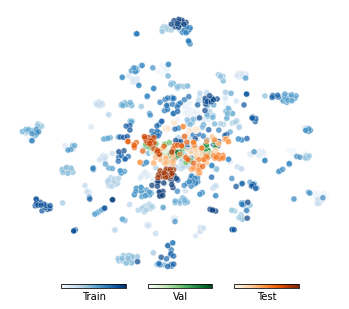

In [13]:
# mix up
X_train_PCA = PCA(n_components=100).fit_transform(X_train)
d_train = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)

X_val_PCA = PCA(n_components=100).fit_transform(X_val)
d_val = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=100).fit_transform(X_test)
d_test = TSNE(perplexity=30, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_mix_30.png")

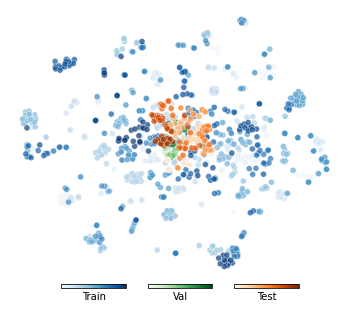

In [14]:
# mix up
X_train_PCA = PCA(n_components=100).fit_transform(X_train)
d_train = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)

X_val_PCA = PCA(n_components=100).fit_transform(X_val)
d_val = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=100).fit_transform(X_test)
d_test = TSNE(perplexity=50, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_mix_50.png")

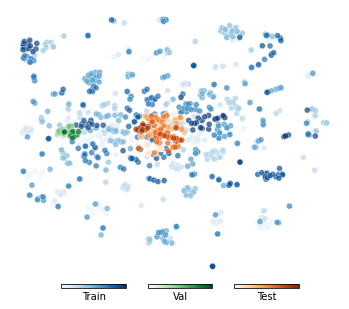

In [15]:
# mix up
X_train_PCA = PCA(n_components=100).fit_transform(X_train)
d_train = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_train_PCA)

X_val_PCA = PCA(n_components=100).fit_transform(X_val)
d_val = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_val_PCA)

X_test_PCA = PCA(n_components=100).fit_transform(X_test)
d_test = TSNE(perplexity=80, n_iter=5000, learning_rate=20).fit_transform(X_test_PCA)

scatter_plot(d_train, Y_train, d_val, Y_val, d_test, Y_test, "iwildcam_mix_80.png")